In [1]:
# Code source: Gaël Varoquaux
#              Andreas Müller
# Modified for documentation by Jaques Grobler
# License: BSD 3 clause

# basic tools
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap

In [2]:
PATH = '/home/disk/orca/adaley17/MLGEO2024_TC_Tracks_Intensity/data/'
bt_data = 'clean/cleaned_best_track_data.csv'
ships_data = 'ai_ready/ai_ready_SHIPS_data.csv'

df_SHIPS = pd.read_csv(os.path.join(PATH, ships_data))
df_BT = pd.read_csv(os.path.join(PATH, bt_data))

In [3]:
df_SHIPS


,Original_Times,Code,Times,Daily_SST_Avg,Mid_Level_RH,Vert_Vel,Vshear,MSLP,Vmax,Latitude,Longitude
0,1982-06-02 12:00:00,AL011982,-12.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1982-06-02 12:00:00,AL011982,-6.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,1982-06-02 12:00:00,AL011982,0.0,27.1,57.0,6.631183,15.227542,1005.0,10.28888,21.7,87.1
3,1982-06-02 12:00:00,AL011982,6.0,27.8,53.0,3.966363,15.536209,1004.0,12.86110,22.2,86.5
4,1982-06-02 12:00:00,AL011982,12.0,27.9,56.0,4.403641,15.330431,1003.0,15.43332,22.6,85.8
...,...,...,...,...,...,...,...,...,...,...,...
318545,2022-11-11 12:00:00,AL172022,96.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
318546,2022-11-11 12:00:00,AL172022,102.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
318547,2022-11-11 12:00:00,AL172022,108.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
318548,2022-11-11 12:00:00,AL172022,114.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [4]:
df_BT.head()

,ISO_TIME,USA_ATCF_ID,NAME,DIST2LAND,LANDFALL,STORM_SPEED,STORM_DIR,USA_LAT,USA_LON,USA_WIND,WMO_WIND,WMO_PRES,USA_PRES,USA_RMW,USA_WSPD
0,1982-06-02 12:00:00,AL011982,ALBERTO,22,40744.0,3.601108,47,21.7000,-87.1000,10.288880,10.28888,1005,1005.0,NaN,10.288880
1,1982-06-02 15:00:00,AL011982,ALBERTO,59,109268.0,4.115552,48,21.9551,-86.8077,11.317768,NaN,,1004.0,NaN,11.317768
2,1982-06-02 18:00:00,AL011982,ALBERTO,93,172236.0,4.115552,52,22.2000,-86.5000,12.861100,12.86110,1004,1004.0,NaN,12.861100
3,1982-06-02 21:00:00,AL011982,ALBERTO,130,209276.0,4.115552,58,22.4224,-86.1650,13.889988,NaN,,1003.0,NaN,13.889988
4,1982-06-03 00:00:00,AL011982,ALBERTO,113,181496.0,4.115552,68,22.6000,-85.8000,15.433320,15.43332,1003,1003.0,NaN,15.433320


## Attempting to use BT Data as verification

### Subsetting the first 30 hours of BT and SHIPS Data

In [5]:
# Subsampling the data so that we only have the first 24 hours of each storm
df_BT_24 = df_BT.groupby('USA_ATCF_ID').head(30) #This will be our Obseravtion data


# Filter the DataFrame for Times from 0 to 24 for each Code
filtered_df = df_SHIPS[(df_SHIPS['Times'] >= 0) & (df_SHIPS['Times'] <= 30)]

# Group by Code and extract the relevant columns
df_SHIPS_24 = filtered_df.groupby('Code').apply(lambda x: x[['Original_Times', 'Code', 'Times', 'Latitude', 'Longitude', 'Vmax', 'MSLP', 'Daily_SST_Avg', 'Mid_Level_RH', 'Vshear', 'Vert_Vel']]).reset_index(drop=True)

# df_SHIPS_24


<ipython-input-5-70ef97ec7642>:9: FutureWarning: Not prepending group keys to the result index of transform-like apply. In the future, the group keys will be included in the index, regardless of whether the applied function returns a like-indexed object.
To preserve the previous behavior, use

	>>> .groupby(..., group_keys=False)

To adopt the future behavior and silence this warning, use 

	>>> .groupby(..., group_keys=True)
  df_SHIPS_24 = filtered_df.groupby('Code').apply(lambda x: x[['Original_Times', 'Code', 'Times', 'Latitude', 'Longitude', 'Vmax', 'MSLP', 'Daily_SST_Avg', 'Mid_Level_RH', 'Vshear', 'Vert_Vel']]).reset_index(drop=True)


### Identifying common codes across datasets

In [6]:
# Set 'Code' as an index level in df_SHIPS_24
df_SHIPS_24 = df_SHIPS_24.set_index('Code')

# Extract the unique IDs from both dataframes
bt_ids = df_BT_24['USA_ATCF_ID'].unique()
ships_ids = df_SHIPS_24.index.get_level_values('Code').unique()

# Find common IDs
common_ids = np.intersect1d(bt_ids, ships_ids)

# Find IDs only in df_BT_24
bt_only_ids = np.setdiff1d(bt_ids, ships_ids)

# Find IDs only in df_SHIPS_24
ships_only_ids = np.setdiff1d(ships_ids, bt_ids)

print(f"Common IDs: {len(common_ids)}")
print(f"IDs only in df_BT_24: {len(bt_only_ids)}")
print(f"IDs only in df_SHIPS_24: {len(ships_only_ids)}")



Common IDs: 539
IDs only in df_BT_24: 23
IDs only in df_SHIPS_24: 71


### Keeping Common IDs

In [7]:
# Filter df_BT_24 to keep only common IDs
df_BT_24_common = df_BT_24[df_BT_24['USA_ATCF_ID'].isin(common_ids)]

# Filter df_SHIPS_24 to keep only common IDs
df_SHIPS_24_common = df_SHIPS_24[df_SHIPS_24.index.get_level_values('Code').isin(common_ids)]

# Check if the lengths of the filtered dataframes are the same
print(f"Length of df_BT_24_common: {len(df_BT_24_common)}")
print(f"Length of df_SHIPS_24_common: {len(df_SHIPS_24_common)}")

Length of df_BT_24_common: 15287
Length of df_SHIPS_24_common: 79440


### Matching Times

In [8]:
new_times = [None] * len(df_SHIPS_24_common['Original_Times']) #Empty list to store the new times
for i in range(len(df_SHIPS_24_common['Original_Times'])):
    
    original_time = pd.to_datetime(df_SHIPS_24_common['Original_Times'].iloc[i]) #Time when prediction was made

    # print(original_time, original_time + pd.Timedelta(hours=df_SHIPS_24_common['Times'].iloc[i]))
    new_times[i] = original_time + pd.Timedelta(hours=df_SHIPS_24_common['Times'].iloc[i]) #Add the time of prediction to the time when prediction was made

    
df_SHIPS_24_common.loc[:, 'New_Times'] = new_times #Add the new times to the DataFrame

<ipython-input-8-72a982439e21>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_SHIPS_24_common.loc[:, 'New_Times'] = new_times #Add the new times to the DataFrame


In [9]:
df_SHIPS_24_common

# Convert ISO_TIME to datetime format
df_BT_24_common['ISO_TIME'] = pd.to_datetime(df_BT_24_common['ISO_TIME'])

df_merged = pd.merge(df_SHIPS_24_common.reset_index(), 
df_BT_24_common[['ISO_TIME', 'USA_ATCF_ID', 'USA_WSPD', 'USA_PRES', 
                    'WMO_WIND', 'USA_WIND', 'STORM_DIR', 'WMO_PRES']], 
            left_on=['New_Times', 'Code'], right_on=['ISO_TIME', 'USA_ATCF_ID'], how='inner')

<ipython-input-9-cfb0873efbe0>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_BT_24_common['ISO_TIME'] = pd.to_datetime(df_BT_24_common['ISO_TIME'])


In [10]:
df_merged_clean = df_merged.dropna()
df_merged_clean = df_merged_clean.drop(columns=['Times', 'Original_Times', 'ISO_TIME'])
df_merged_clean

,Code,Latitude,Longitude,Vmax,MSLP,Daily_SST_Avg,Mid_Level_RH,Vshear,Vert_Vel,New_Times,USA_ATCF_ID,USA_WSPD,USA_PRES,WMO_WIND,USA_WIND,STORM_DIR,WMO_PRES
0,AL011982,21.7,87.1,10.28888,1005.0,27.1,57.0,15.227542,6.631183,1982-06-02 12:00:00,AL011982,10.28888,1005.0,10.28888,10.28888,47,1005
1,AL011982,22.2,86.5,12.86110,1004.0,27.8,53.0,15.536209,3.966363,1982-06-02 18:00:00,AL011982,12.86110,1004.0,12.86110,12.86110,52,1004
2,AL011982,22.2,86.5,12.86110,1004.0,27.8,53.0,15.536209,3.966363,1982-06-02 18:00:00,AL011982,12.86110,1004.0,12.86110,12.86110,52,1004
3,AL011982,22.6,85.8,15.43332,1003.0,27.9,56.0,15.330431,4.403641,1982-06-03 00:00:00,AL011982,15.43332,1003.0,15.43332,15.43332,68,1003
4,AL011982,22.6,85.8,15.43332,1003.0,27.9,56.0,15.330431,4.403641,1982-06-03 00:00:00,AL011982,15.43332,1003.0,15.43332,15.43332,68,1003
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
32379,AL172022,26.5,77.3,30.86664,985.0,27.6,49.0,18.571428,5.730906,2022-11-09 18:00:00,AL172022,30.86664,985.0,30.86664,30.86664,270,985
32380,AL172022,26.5,77.3,30.86664,985.0,27.5,49.0,18.571428,5.730906,2022-11-09 18:00:00,AL172022,30.86664,985.0,30.86664,30.86664,270,985
32381,AL172022,26.5,77.3,30.86664,985.0,27.5,49.0,18.571428,5.730906,2022-11-09 18:00:00,AL172022,30.86664,985.0,30.86664,30.86664,270,985
32382,AL172022,26.5,77.3,30.86664,985.0,27.5,49.0,18.571428,5.730906,2022-11-09 18:00:00,AL172022,30.86664,985.0,30.86664,30.86664,270,985


## Cross Validation 

In [11]:
t = np.asarray(df_merged_clean['New_Times'])
E = np.asarray(df_merged_clean['Vmax'])



In [12]:
from sklearn.datasets import load_diabetes
from sklearn.model_selection import train_test_split
from sklearn.ensemble import ExtraTreesRegressor
from sklearn.model_selection import ShuffleSplit

n=1 # we do this selection once
v_size = 0.3 # 30% of the data will be randomly selected to be the validation set.

rs = ShuffleSplit(n_splits=n, test_size=.3, random_state=0)
for train_index, val_index in rs.split(E):
    E_train, E_val = E[train_index], E[val_index]
    t_train, t_val = t[train_index], t[val_index]

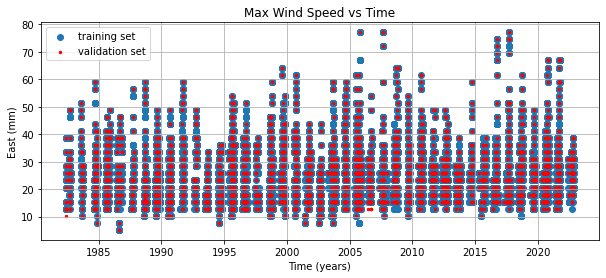

In [13]:
gridsize = (1, 1)
fig = plt.figure(figsize=(10,4))

ax1 = plt.subplot2grid(gridsize, (0,0), colspan=1, rowspan=1)

ax1.scatter(t_train,E_train,marker="o");plt.grid(True);plt.ylabel('East (mm)')
ax1.scatter(t_val,E_val,marker="o",s=6,c="red")
ax1.set_xlabel('Time (years)')
ax1.set_title('Max Wind Speed vs Time')
ax1.legend(['training set','validation set'])
plt.show()

Training set: Coefficient / Velocity eastward (m/s):  0.8743188765897795
MSE (mean square error) on training set (m/s): 12.26
Coefficient of determination on training set: 0.86
MSE on validation set (mm): 16.05 and coefficient of determiniation on 0.80


Text(0.5, 1.0, 'Random selection for data split')

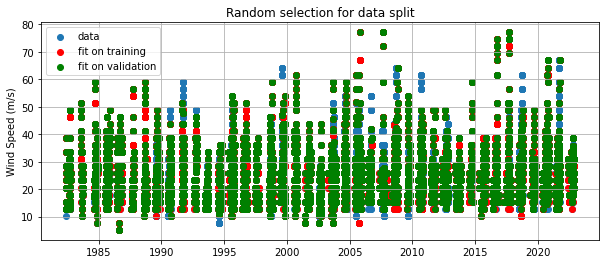

In [14]:
from sklearn.ensemble import ExtraTreesRegressor
from sklearn.metrics import mean_squared_error, r2_score

regr = ExtraTreesRegressor()

t_train = t_train.reshape(len(t_train), 1)
t_val = t_val.reshape(len(t_val), 1)

regr.fit(t_train, E_train)
# We will first predict the fit:
Epred=regr.predict(t_train) 
Epred_val=regr.predict(t_val)

# The coefficients
print('Training set: Coefficient / Velocity eastward (m/s): ', regr.score(t_train, E_train))

print('MSE (mean square error) on training set (m/s): %.2f'
      % mean_squared_error(Epred, E_train))
# The coefficient of determination: 1 is the perfect prediction
print('Coefficient of determination on training set: %.2f'
      % r2_score(Epred, E_train))

print('MSE on validation set (mm): %.2f and coefficient of determiniation on %.2f' %(mean_squared_error(Epred_val, E_val), r2_score(Epred_val, E_val)))

gridsize = (1, 1)
fig = plt.figure(figsize=(10,4))

ax1 = plt.subplot2grid(gridsize, (0,0), colspan=1, rowspan=1)

ax1.scatter(t,E)
ax1.scatter(t_train,Epred,color="red")
ax1.scatter(t_val,Epred_val,color="green")
ax1.grid(True)
ax1.set_ylabel('Wind Speed (m/s)')


plt.legend(['data','fit on training','fit on validation'])
plt.title('Random selection for data split')

## K-fold Cross Validation

In [15]:
from sklearn.model_selection import KFold

# let's try on 10-folds, 10 adjacent split of the data.
k=10
kf = KFold(n_splits=k)

vel = np.zeros(k) # initalize a vector to store the regression values
mse_train = np.zeros(k)
mse_val = np.zeros(k)
r2s = np.zeros(k)
i=0
for train_index, val_index in kf.split(E):    
    E_train, E_val = E[train_index], E[val_index]
    t_train, t_val = t[train_index].reshape(-1, 1), t[val_index].reshape(-1, 1)
    # now fit the data on the training set.
    regr = ExtraTreesRegressor()
    # Fit on training data:
    regr.fit(t_train,E_train)
    # We will first predict the fit:
    Epred_train=regr.predict(t_train) 
    Epred_val=regr.predict(t_val) 

    # The coefficients
    vel[i]= regr.feature_importances_[0]
    mse_val[i]= mean_squared_error(E_val, Epred_val)
    mse_train[i]= mean_squared_error(E_train, Epred_train)
    r2s[i]=r2_score(E_train, Epred_train)
    i+=1

# the data shows clearly a trend, so the predictions of the trends are close to each other:
print("mean of the velocity estimates %4.2f and the standard deviation %4.2f"%(np.mean(vel),np.std(vel)))
# the test error is the average of the mean-square-errors
print("mean MSE for training set : %4.2f and the validation set: %4.2f"%(np.mean(mse_train),np.mean(mse_val)))


mean of the velocity estimates 1.00 and the standard deviation 0.00
mean MSE for training set : 12.75 and the validation set: 133.05


In [52]:
data = np.array(df_merged_clean.drop(columns=['Vmax', 'New_Times', 'Code', 'USA_ATCF_ID', 'USA_WIND', 'WMO_WIND'])).astype(float)
data = data[~np.isnan(data).any(axis=1)]
y = np.asarray(df_merged_clean['Vmax'])
y = y[~np.isnan(y)]

In [53]:
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
scaler = MinMaxScaler()
scaler.fit_transform(data)# fit the model for data normalization
newdata = scaler.transform(data) # transform the data. watch that data was converted to a numpy array

# Split data into 50% train and 50% test subsets
print(f"There are {data.shape[0]} data samples")
X_train, X_test, y_train, y_test = train_test_split(
    data, y, test_size=0.2, shuffle=False)

There are 31316 data samples


In [54]:
X_train

array([[  21.7,   87.1, 1005. , ..., 1005. ,   47. , 1005. ],
       [  22.2,   86.5, 1004. , ..., 1004. ,   52. , 1004. ],
       [  22.2,   86.5, 1004. , ..., 1004. ,   52. , 1004. ],
       ...,
       [  22.4,   87.9, 1005. , ..., 1005. ,    6. , 1005. ],
       [  22.4,   87.9, 1005. , ..., 1005. ,    6. , 1005. ],
       [  23.2,   87.8, 1003. , ..., 1003. ,    7. , 1003. ]])

### Pasting

In [55]:
from sklearn.ensemble import BaggingRegressor
from sklearn.ensemble import ExtraTreesRegressor
from sklearn.model_selection import cross_val_score

bag_reg_pass = BaggingRegressor(
    base_estimator=ExtraTreesRegressor(), n_estimators=100,  # n_estimators is the number of models to train
    max_samples=1000, bootstrap=False, # bootstrap is for bagging vs pasting
    n_jobs=-1, # number of CPU cores independently used for training and prediction. Use -1 for all available cores
    )
scores = cross_val_score(bag_reg_pass, data, y, cv=5)
print('mean accuracy', scores.mean())

mean accuracy 0.9987326223871124


### Bagging

In [56]:
bag_reg_boost = BaggingRegressor(
    base_estimator=ExtraTreesRegressor(), n_estimators=100,  # n_estimators is the number of models to train
    max_samples=1000, bootstrap=True, # bootstrap is for bagging vs pasting
    n_jobs=-1, # number of CPU cores independently used for training and prediction. Use -1 for all available cores
    )
bag_reg_boost.fit(X_train, y_train)
scores = cross_val_score(bag_reg_boost, data, y, cv=5)
print('mean accuracy', scores.mean())

mean accuracy 0.9987042963531696


In [57]:
from sklearn.model_selection import cross_val_predict

bag_reg = BaggingRegressor(
    base_estimator = ExtraTreesRegressor(),n_estimators=100,  # n_estimator is the number of models to train
    max_samples=100,bootstrap=True, # bootstrap is for bagging vs pasting
    n_jobs=-1,oob_score=True,#number of CPU cores independently used for training and prediction. Use -1 for all available score
    )

bag_reg_pass.fit(X_train, y_train)
scores=cross_val_predict(bag_reg,X_test,y_test,cv=5) # the size of max_samples


## Visualize Model Performance

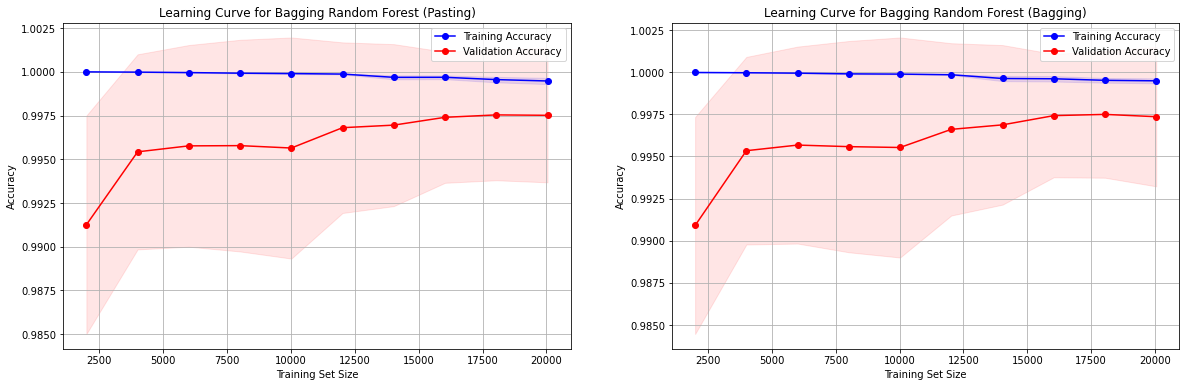

In [ ]:

from sklearn.model_selection import learning_curve

# Generate learning curves for bag_reg_pass
train_sizes, train_scores, val_scores = learning_curve(
    bag_reg_pass, X_train, y_train, cv=5, scoring='r2', n_jobs=-1, 
     train_sizes=np.linspace(0.1, 1.0, 10)
)

# Calculate mean and standard deviation for training and validation scores
train_mean = np.nanmean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)
val_mean = np.mean(val_scores, axis=1)
val_std = np.std(val_scores, axis=1)

# Generate learning curves for bag_reg_boost
train_sizes_boost, train_scores_boost, val_scores_boost = learning_curve(
    bag_reg_boost, X_train, y_train, cv=5, scoring='r2', n_jobs=-1, 
     train_sizes=np.linspace(0.1, 1.0, 10)
)

# Calculate mean and standard deviation for training and validation scores
train_mean_boost = np.nanmean(train_scores_boost, axis=1)
train_std_boost = np.std(train_scores_boost, axis=1)
val_mean_boost = np.mean(val_scores_boost, axis=1)
val_std_boost = np.std(val_scores_boost, axis=1)

# Plot learning curves
fig, axes = plt.subplots(1, 2, figsize=(20, 6))

# Plot for bag_reg_pass
axes[0].plot(train_sizes, train_mean, label="Training Accuracy", color="blue", marker='o')
axes[0].plot(train_sizes, val_mean, label="Validation Accuracy", color="red", marker='o')
axes[0].fill_between(train_sizes, train_mean - train_std, train_mean + train_std, color="blue", alpha=0.1)
axes[0].fill_between(train_sizes, val_mean - val_std, val_mean + val_std, color="red", alpha=0.1)
axes[0].set_xlabel("Training Set Size")
axes[0].set_ylabel("Accuracy")
axes[0].set_title("Learning Curve for Extra Tree Regressor (Pasting)")
axes[0].legend(loc="best")
axes[0].grid()

# Plot for bag_reg_boost
axes[1].plot(train_sizes_boost, train_mean_boost, label="Training Accuracy", color="blue", marker='o')
axes[1].plot(train_sizes_boost, val_mean_boost, label="Validation Accuracy", color="red", marker='o')
axes[1].fill_between(train_sizes_boost, train_mean_boost - train_std_boost, train_mean_boost + train_std_boost, color="blue", alpha=0.1)
axes[1].fill_between(train_sizes_boost, val_mean_boost - val_std_boost, val_mean_boost + val_std_boost, color="red", alpha=0.1)
axes[1].set_xlabel("Training Set Size")
axes[1].set_ylabel("Accuracy")
axes[1].set_title("Learning Curve for Bagging Extra Tree Regressor (Bagging)")
axes[1].legend(loc="best")
axes[1].grid()

plt.show()

It appears that in this model boostrapping and pasting does not make asignificant difference. Both models show good training  and validation accuarcy via the $R^2$ value. There is some separation between the curves but this separation is very small  which indicates good generalization.

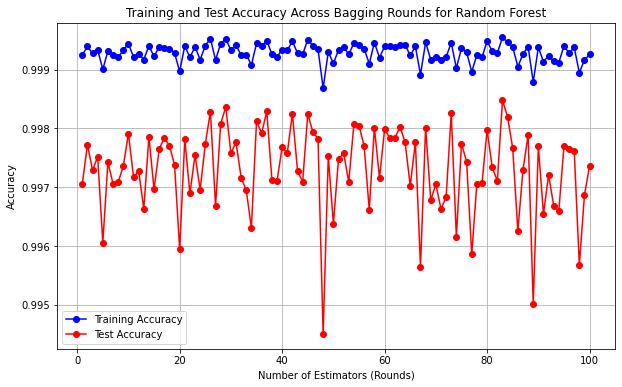

In [67]:
from sklearn.metrics import mean_squared_error, r2_score

# Initialize lists to store accuracies for each round
train_accuracies = []
test_accuracies = []
n_estimators = 100  # Number of bagging rounds to evaluate

# Loop over each round of bagging, increasing the number of estimators each time
for i in range(1, n_estimators + 1):
    # Define the Bagging Random Forest model with increasing number of estimators
    bag_reg_boost = BaggingRegressor(
        base_estimator=ExtraTreesRegressor(), n_estimators=i,  # n_estimators is the number of models to train
        max_samples=1000, bootstrap=False, # bootstrap is for bagging vs pasting
        n_jobs=-1, # number of CPU cores independently used for training and prediction. Use -1 for all available cores
        )
    
    # Fit the model on the training data
    bag_reg_pass.fit(X_train, y_train)
    
    # Calculate R^2 score for training and test sets
    train_accuracy = r2_score(y_train, bag_reg_pass.predict(X_train))
    test_accuracy = r2_score(y_test, bag_reg_pass.predict(X_test))
    
    # Store the accuracies
    train_accuracies.append(train_accuracy)
    test_accuracies.append(test_accuracy)

# Plot Training and Test Accuracy Across Training Rounds
plt.figure(figsize=(10, 6))
plt.plot(range(1, n_estimators + 1), train_accuracies, label="Training Accuracy", marker='o', color="blue")
plt.plot(range(1, n_estimators + 1), test_accuracies, label="Test Accuracy", marker='o', color="red")
plt.xlabel("Number of Estimators (Rounds)")
plt.ylabel("Accuracy")
plt.title("Training and Test Accuracy Across Bagging Rounds for Random Forest")
plt.legend(loc="best")
plt.grid()
plt.show()

The model performs quite well in both training set and validation set since there is not a significant fluctuation as the number of rounds increase.